In [1]:
import os
import sys
from dotenv import load_dotenv
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torchinfo import summary

load_dotenv()

sys.path.append(os.path.abspath(os.path.join("../..")))
from src.datasets.kaggledataset import KaggleDataset  # noqa: E402
from src.models.convoluationaltransformer.convtrans_v1 import Captcha_Convolutional_Transformer_V1

In [11]:
captcha_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomInvert(p=0.5),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
    ]
)
dataset = KaggleDataset(os.environ["KAGGLE_ROOT_DIR"], transform=captcha_transformation, preload=False) # TODO: Set preload to True

In [12]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_size, val_size, test_size

(90449, 11306, 11307)

In [13]:
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [14]:
model = Captcha_Convolutional_Transformer_V1(num_chars=len(dataset.vocab) + 1)  # Add Blank Character to Vocabulary
summary(model, input_size=(1, 1, 40, 150))

/nfs/home/tpz8688/Captcha-Recognition/src/models/convoluationaltransformer/convtrans_v1.py:93: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(


Layer (type:depth-idx)                        Output Shape              Param #
Captcha_Convolutional_Transformer_V1          [1, 37, 63]               --
├─Sequential: 1-1                             [1, 256, 5, 37]           --
│    └─Conv2d: 2-1                            [1, 32, 40, 150]          320
│    └─BatchNorm2d: 2-2                       [1, 32, 40, 150]          64
│    └─SiLU: 2-3                              [1, 32, 40, 150]          --
│    └─MaxPool2d: 2-4                         [1, 32, 20, 75]           --
│    └─Conv2d: 2-5                            [1, 64, 20, 75]           18,496
│    └─BatchNorm2d: 2-6                       [1, 64, 20, 75]           128
│    └─SiLU: 2-7                              [1, 64, 20, 75]           --
│    └─MaxPool2d: 2-8                         [1, 64, 10, 37]           --
│    └─Conv2d: 2-9                            [1, 128, 10, 37]          73,856
│    └─BatchNorm2d: 2-10                      [1, 128, 10, 37]          256
│    └─Si

In [15]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    ctc_loss = nn.CTCLoss(blank=0)  # 0 is usually reserved for the 'blank' character
    total_loss = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        # model output shape: [Batch, Time_Steps, Num_Chars]
        logits = model(images)

        # Prepare for CTC (CTC expects [Time_Steps, Batch, Num_Chars])
        logits = logits.permute(1, 0, 2)
        log_probs = nn.functional.log_softmax(logits, dim=2)

        # Create lengths tensors
        batch_size = images.size(0)
        input_lengths = torch.full(
            (batch_size,), log_probs.size(0), dtype=torch.long
        ).to(device)
        target_lengths = torch.full((batch_size,), labels.size(1), dtype=torch.long).to(
            device
        )

        # Calculate Loss
        loss = ctc_loss(log_probs, labels, input_lengths, target_lengths)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
def validate(model, dataloader, device):
    model.eval()
    ctc_loss = nn.CTCLoss(blank=0)
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images).permute(1, 0, 2)
            log_probs = nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.full(
                (batch_size,), log_probs.size(0), dtype=torch.long
            ).to(device)
            target_lengths = torch.full(
                (batch_size,), labels.size(1), dtype=torch.long
            ).to(device)

            loss = ctc_loss(log_probs, labels, input_lengths, target_lengths)
            val_loss += loss.item()

    return val_loss / len(dataloader)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',    # We want to minimize loss
    factor=0.5,    # Multiply LR by 0.5 (halve it) when stuck
    patience=3,    # Wait 3 epochs with no improvement before dropping
)

num_epochs = 30
best_val_loss = float('inf')  # Initialize with infinity

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)

    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"LR: {current_lr:.6f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model.SAVE_DIR / "v1.pth")
        print(f"--> New best model saved (Val Loss: {best_val_loss:.4f})")
    
    print("-" * 30)

Training:   0%|          | 0/707 [00:00<?, ?it/s]

Training: 100%|██████████| 707/707 [00:28<00:00, 24.45it/s]


Epoch 1/30
LR: 0.000500 | Train Loss: 0.3817 | Val Loss: 0.3892
--> New best model saved (Val Loss: 0.3892)
------------------------------


Training: 100%|██████████| 707/707 [00:29<00:00, 24.34it/s]


Epoch 2/30
LR: 0.000500 | Train Loss: 0.3749 | Val Loss: 0.3709
--> New best model saved (Val Loss: 0.3709)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.57it/s]


Epoch 3/30
LR: 0.000500 | Train Loss: 0.3711 | Val Loss: 0.3747
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.46it/s]


Epoch 4/30
LR: 0.000500 | Train Loss: 0.3662 | Val Loss: 0.3652
--> New best model saved (Val Loss: 0.3652)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.38it/s]


Epoch 5/30
LR: 0.000500 | Train Loss: 0.3517 | Val Loss: 0.3615
--> New best model saved (Val Loss: 0.3615)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.61it/s]


Epoch 6/30
LR: 0.000500 | Train Loss: 0.3466 | Val Loss: 0.3547
--> New best model saved (Val Loss: 0.3547)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.38it/s]


Epoch 7/30
LR: 0.000500 | Train Loss: 0.3503 | Val Loss: 0.3707
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.61it/s]


Epoch 8/30
LR: 0.000500 | Train Loss: 0.3434 | Val Loss: 0.3544
--> New best model saved (Val Loss: 0.3544)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.56it/s]


Epoch 9/30
LR: 0.000500 | Train Loss: 0.3399 | Val Loss: 0.3445
--> New best model saved (Val Loss: 0.3445)
------------------------------


Training: 100%|██████████| 707/707 [00:29<00:00, 24.34it/s]


Epoch 10/30
LR: 0.000500 | Train Loss: 0.3392 | Val Loss: 0.3720
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.57it/s]


Epoch 11/30
LR: 0.000500 | Train Loss: 0.3280 | Val Loss: 0.3605
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.45it/s]


Epoch 12/30
LR: 0.000500 | Train Loss: 0.3368 | Val Loss: 0.3620
------------------------------


Training: 100%|██████████| 707/707 [00:29<00:00, 24.36it/s]


Epoch 13/30
LR: 0.000250 | Train Loss: 0.3236 | Val Loss: 0.3518
------------------------------


Training: 100%|██████████| 707/707 [00:29<00:00, 24.32it/s]


Epoch 14/30
LR: 0.000250 | Train Loss: 0.2493 | Val Loss: 0.2900
--> New best model saved (Val Loss: 0.2900)
------------------------------


Training: 100%|██████████| 707/707 [00:29<00:00, 24.30it/s]


Epoch 15/30
LR: 0.000250 | Train Loss: 0.2270 | Val Loss: 0.2814
--> New best model saved (Val Loss: 0.2814)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.60it/s]


Epoch 16/30
LR: 0.000250 | Train Loss: 0.2219 | Val Loss: 0.2867
------------------------------


Training: 100%|██████████| 707/707 [00:29<00:00, 24.31it/s]


Epoch 17/30
LR: 0.000250 | Train Loss: 0.2203 | Val Loss: 0.2868
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.49it/s]


Epoch 18/30
LR: 0.000250 | Train Loss: 0.2165 | Val Loss: 0.2851
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.39it/s]


Epoch 19/30
LR: 0.000125 | Train Loss: 0.2159 | Val Loss: 0.2946
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.47it/s]


Epoch 20/30
LR: 0.000125 | Train Loss: 0.1824 | Val Loss: 0.2687
--> New best model saved (Val Loss: 0.2687)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.50it/s]


Epoch 21/30
LR: 0.000125 | Train Loss: 0.1709 | Val Loss: 0.2690
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.43it/s]


Epoch 22/30
LR: 0.000125 | Train Loss: 0.1687 | Val Loss: 0.2749
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.42it/s]


Epoch 23/30
LR: 0.000125 | Train Loss: 0.1636 | Val Loss: 0.2740
------------------------------


Training: 100%|██████████| 707/707 [00:29<00:00, 24.26it/s]


Epoch 24/30
LR: 0.000063 | Train Loss: 0.1609 | Val Loss: 0.2693
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.41it/s]


Epoch 25/30
LR: 0.000063 | Train Loss: 0.1463 | Val Loss: 0.2654
--> New best model saved (Val Loss: 0.2654)
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.44it/s]


Epoch 26/30
LR: 0.000063 | Train Loss: 0.1391 | Val Loss: 0.2669
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.46it/s]


Epoch 27/30
LR: 0.000063 | Train Loss: 0.1368 | Val Loss: 0.2682
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.53it/s]


Epoch 28/30
LR: 0.000063 | Train Loss: 0.1334 | Val Loss: 0.2731
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.54it/s]


Epoch 29/30
LR: 0.000031 | Train Loss: 0.1324 | Val Loss: 0.2694
------------------------------


Training: 100%|██████████| 707/707 [00:28<00:00, 24.48it/s]


Epoch 30/30
LR: 0.000031 | Train Loss: 0.1256 | Val Loss: 0.2725
------------------------------


In [19]:
model = Captcha_Convolutional_Transformer_V1(num_chars=len(dataset.vocab) + 1)
state_dict = torch.load(Captcha_Convolutional_Transformer_V1.SAVE_DIR / "v1.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval() 

print(f"Model successfully loaded from {Captcha_Convolutional_Transformer_V1.SAVE_DIR / "v1.pth"}")


Model successfully loaded from /nfs/home/tpz8688/Captcha-Recognition/weights/conv_transformer/v1.pth


In [20]:
def decode_predictions(logits, dataset):
    # logits shape: (Time_Steps, Num_Chars)
    # Get the index of the highest probability for each time step
    tokens = torch.argmax(logits, dim=-1)  # Shape: (Time_Steps)

    char_list = []
    for i in range(len(tokens)):
        token = tokens[i].item()

        # CTC Rules:
        # 1. Skip the blank token (index 0)
        # 2. Skip repeated tokens (if the model predicts 'aaaa', it's just 'a')
        if token != 0:
            if i > 0 and tokens[i] == tokens[i - 1]:
                continue
            char_list.append(dataset.idx_to_char[token])

    return "".join(char_list)

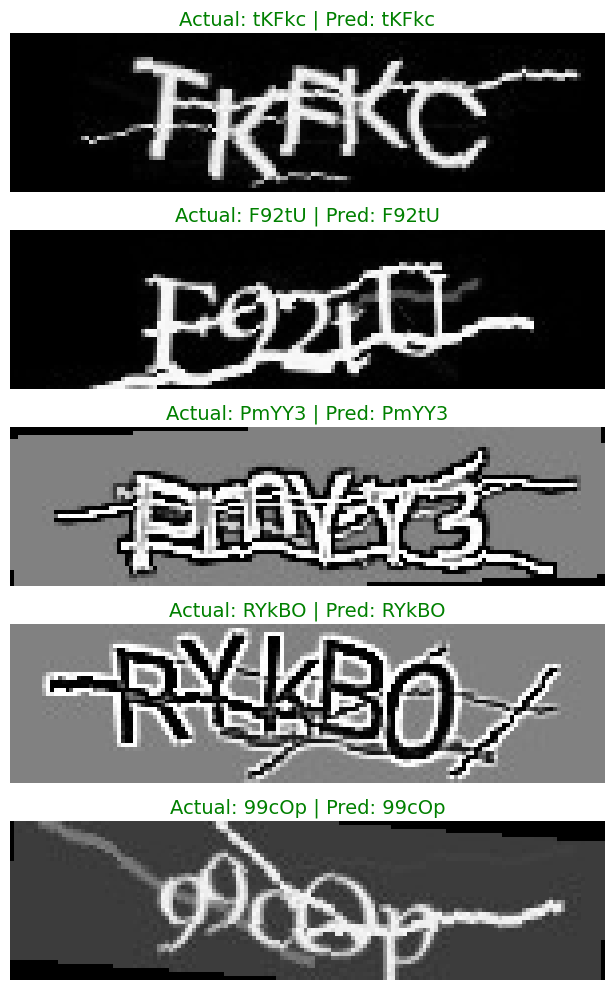

In [22]:
import matplotlib.pyplot as plt
import random


def visualize_predictions(model, dataloader, dataset, device, num_samples=5):
    model.eval()

    # 1. Get just ONE batch without loading the whole dataset
    # We use a loop that breaks immediately to grab the 'first' available batch
    # If your test_loader has shuffle=True, this will be a random batch.
    images, labels = next(iter(dataloader))

    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    plt.figure(figsize=(15, 10))

    batch_size = images.size(0)
    # Pick random indices within this single batch
    indices = random.sample(range(batch_size), min(num_samples, batch_size))

    for i, idx in enumerate(indices):
        img = images[idx].cpu().squeeze().numpy()
        pred_str = decode_predictions(logits[idx], dataset)
        actual_indices = [val.item() for val in labels[idx] if val.item() != 0]
        actual_str = "".join([dataset.idx_to_char[val] for val in actual_indices])

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img, cmap="gray")
        color = "green" if pred_str == actual_str else "red"
        plt.title(f"Actual: {actual_str} | Pred: {pred_str}", color=color, fontsize=14)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Usage:
visualize_predictions(model, test_loader, dataset, device)

In [23]:
import Levenshtein

def run_evaluation(model, dataloader, dataset, device):
    model.eval()
    
    total_samples = 0
    perfect_matches = 0
    
    total_edit_distance = 0
    total_actual_chars = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            logits = model(images) # [Batch, Time, Vocab]
            
            for i in range(images.size(0)):
                # 1. Decode prediction and actual label
                pred_str = decode_predictions(logits[i], dataset)
                
                actual_indices = [val.item() for val in labels[i] if val.item() != 0]
                actual_str = "".join([dataset.idx_to_char[val] for val in actual_indices])
                
                # 2. Update Word Accuracy Stats
                if pred_str == actual_str:
                    perfect_matches += 1
                total_samples += 1
                
                # 3. Update Character Accuracy Stats (Levenshtein)
                distance = Levenshtein.distance(pred_str, actual_str)
                total_edit_distance += distance
                total_actual_chars += len(actual_str)

    # Final Calculations
    word_accuracy = (perfect_matches / total_samples) * 100
    
    # Character Error Rate (CER) is distance/total_chars
    # Character Accuracy is 100 - CER
    cer = (total_edit_distance / total_actual_chars) * 100
    char_accuracy = 100 - cer

    print(f"\n" + "="*30)
    print(f"WORD ACCURACY: {word_accuracy:.2f}%")
    print(f"CHAR ACCURACY: {char_accuracy:.2f}%")
    print(f"TOTAL SAMPLES: {total_samples}")
    print("="*30)

    return word_accuracy, char_accuracy

In [24]:
run_evaluation(model, test_loader, test_dataset.dataset, device)

Evaluating: 100%|██████████| 89/89 [00:45<00:00,  1.94it/s]


WORD ACCURACY: 68.97%
CHAR ACCURACY: 89.40%
TOTAL SAMPLES: 11307


(68.97497125674361, 89.39948704342443)